In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyeit import mesh
import os
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
from src.vae2D import vae_model
from sklearn.model_selection import train_test_split
from src.util import plot_mesh_permarray, plot_mesh, load_sim_data, create_trajectory
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from keras import backend as K
import keras_tuner as kt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

2025-04-01 13:59:23.061203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743515963.075963  802736 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743515963.080700  802736 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 13:59:23.097771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1743515971.666177  802736 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [2]:
n_el = 32
mesh_obj = mesh.create(n_el, h0=0.05)

def createAnomaly(ms, x, y, r):
    
    anomaly = [
        PyEITAnomaly_Circle(center=[x, y], r=r, perm=0.9),
    ]
    ms = mesh.set_perm(mesh_obj, anomaly=anomaly, background=0.1)

    return ms

ms = createAnomaly(mesh_obj, 0.5, 0.5, 0.2)

size = 6000
obj_rs = np.random.choice([0.1, 0.15, 0.2], size)

r_pos = np.random.uniform(0, 0.8, size)
a_pos = np.random.uniform(0, 2 * np.pi, size)

x_pos = r_pos * np.cos(a_pos)
y_pos = r_pos * np.sin(a_pos)

perms = list()
for x, y, r in zip(x_pos, y_pos, obj_rs):
    ms = createAnomaly(mesh_obj, x, y, r)
    ms.perm = ms.perm + np.random.normal(scale=0.05, size=ms.perm_array.shape[0])
    perms.append(ms.perm_array)
    
gamma = np.array(perms)


In [3]:
gamma.shape

(6000, 2840)

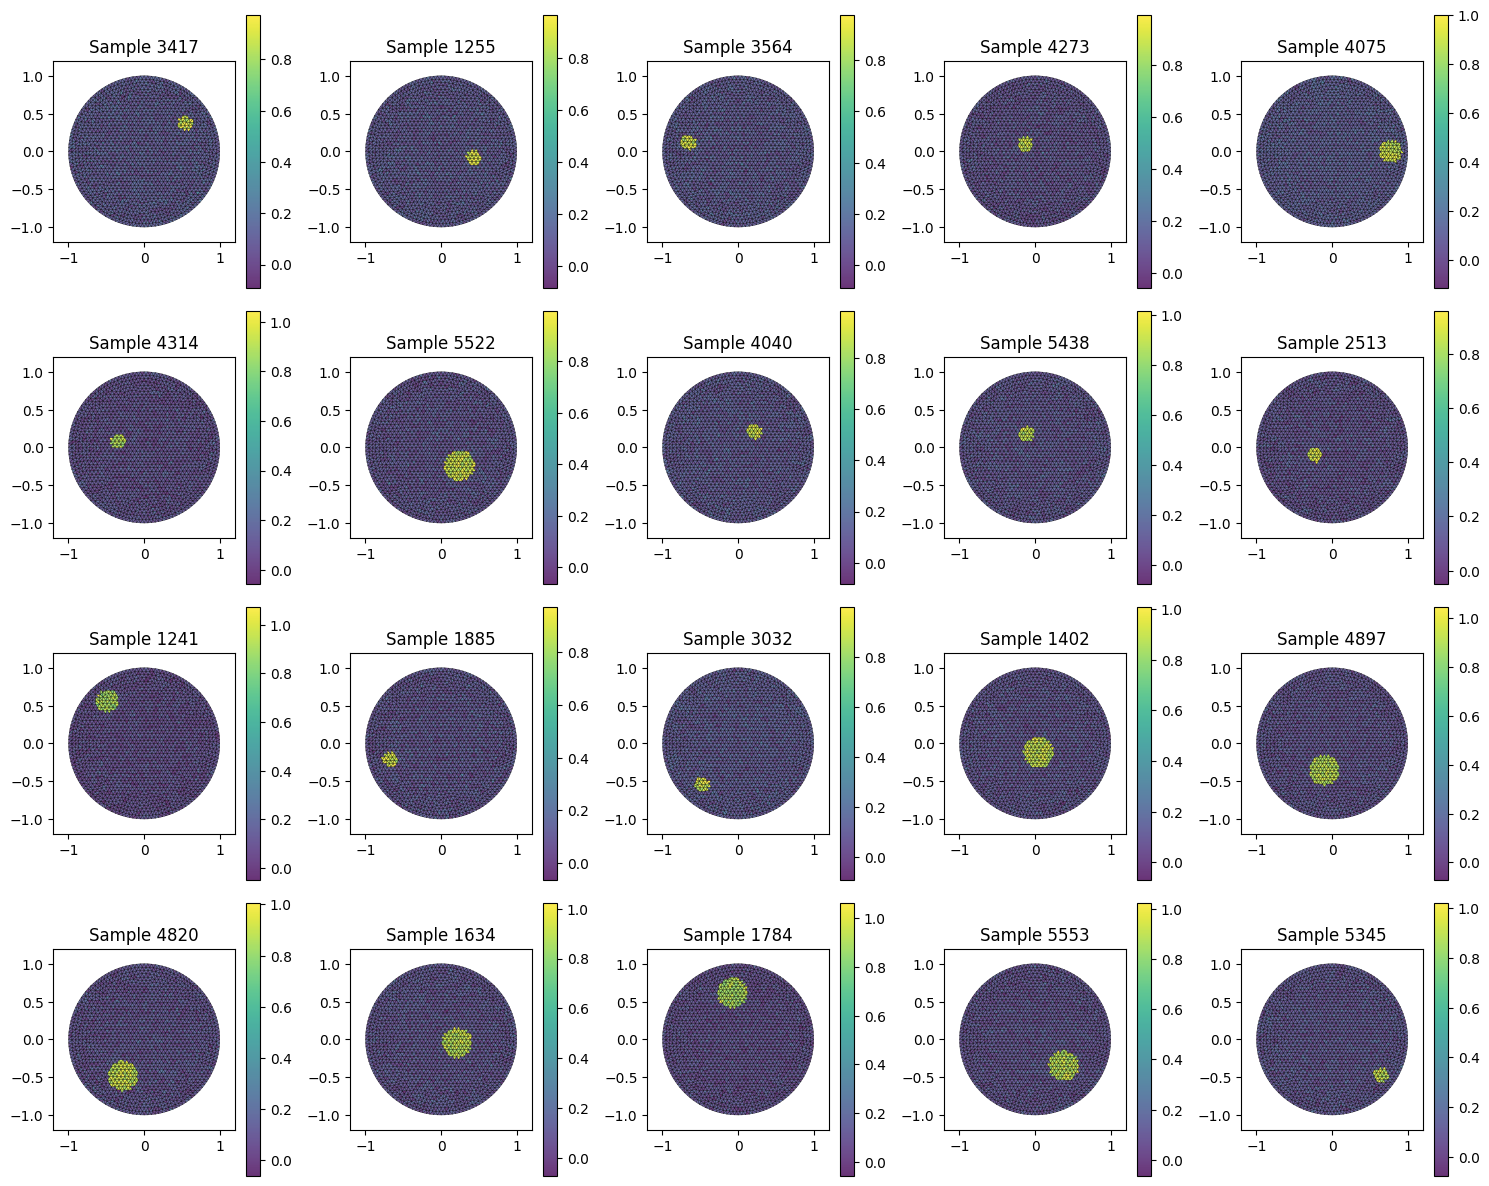

In [4]:
def plot_random_samples(mesh_obj, gamma_array, num_samples=20):

    random_indices = np.random.choice(len(gamma_array), size=num_samples, replace=False)
    
    cols = 5

    rows = int(np.ceil(num_samples / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()
    
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        plot_mesh_permarray(mesh_obj, gamma_array[idx, :], ax=ax, title=f"Sample {idx}")
    
    plt.tight_layout()
    plt.show()

plot_random_samples(mesh_obj, gamma, num_samples=20)

In [6]:
vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [8]:
gamma_train, gamma_test = train_test_split(gamma, test_size=0.1, shuffle = True, random_state=42)

In [10]:
input_shape = gamma_train.shape[1:]  

vae.build(input_shape=(None, *input_shape))

history_vae = vae.fit(gamma_train, epochs=40, batch_size=8, validation_split=0.1)

Epoch 1/40
608/608 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - kl_loss: 1.2079 - loss: 47.9852 - reconstruction_loss: 46.7774 - val_kl_loss: 6.7600 - val_loss: 39.8243 - val_reconstruction_loss: 33.0643
Epoch 2/40
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - kl_loss: 5.7992 - loss: 37.5199 - reconstruction_loss: 31.7207 - val_kl_loss: 6.8688 - val_loss: 36.4371 - val_reconstruction_loss: 29.5683
Epoch 3/40
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - kl_loss: 6.8738 - loss: 34.3703 - reconstruction_loss: 27.4965 - val_kl_loss: 7.5198 - val_loss: 33.4996 - val_reconstruction_loss: 25.9798
Epoch 4/40
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - kl_loss: 7.5331 - loss: 32.9211 - reconstruction_loss: 25.3880 - val_kl_loss: 7.2675 - val_loss: 32.7110 - val_reconstruction_loss: 25.4435
Epoch 5/40
608/608 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - kl_loss: 7.6792 - loss: 31.3749 - reconstruction_loss: 23.6957 - val_kl_loss: 8.2502 - val_loss: 31.0067 - val_reconstruction_loss: 22.7565
Epoch 6/40
608/608 ━

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history_vae.history["loss"], label="Training Loss")
plt.plot(history_vae.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle=':', color='gray', alpha=0.5)
plt.show()

In [ ]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
vae_weights_file = os.path.join(weights_dir, "vae2D.weights.h5")
vae.save_weights(vae_weights_file)
print(f"weights saved at: {vae_weights_file}")